In [21]:
import numpy as np
import matplotlib.pyplot as plt

from os.path import join
import os
from glob import glob
from get_insta_images import download_images
from build_embedings import ImagePredictor
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import torch

import json

In [13]:
root_dir = Path('../restaurant_dataset/')
find_emb = False
restaurants = glob(join(root_dir, '*'))

In [14]:
insta_images = download_images()

Using cache found in /Users/yury/.cache/torch/hub/pytorch_vision_master


https://instagram.frix7-1.fna.fbcdn.net/v/t51.2885-15/e35/c0.37.1007.1007a/s150x150/128532887_184339993346570_8216562181875048158_n.jpg?_nc_ht=instagram.frix7-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=NDR3MCrUDaUAX-NcJeC&tp=1&oh=9e1565c49ddfd1bb74627383e67ab4db&oe=5FF6AB20
https://instagram.frix7-1.fna.fbcdn.net/v/t51.2885-15/e35/c0.180.1440.1440a/s150x150/126336206_865236640682978_2344174815437822524_n.jpg?_nc_ht=instagram.frix7-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=qZg6wskjrswAX9VogZI&tp=1&oh=8ed546ff09ff8ed66e5228a28ac202a8&oe=5FF71913
https://instagram.frix7-1.fna.fbcdn.net/v/t51.2885-15/e35/s150x150/123228945_3329629723802191_5889572144787479607_n.jpg?_nc_ht=instagram.frix7-1.fna.fbcdn.net&_nc_cat=107&_nc_ohc=xU3ByiF7zi4AX810Ule&tp=1&oh=97539e1cd67aa0032c7a9bbc2f63e6ed&oe=5FCF8F4E
https://instagram.frix7-1.fna.fbcdn.net/v/t51.2885-15/e35/c0.180.1440.1440a/s150x150/122828130_1004110713391430_4407864791860020883_n.jpg?_nc_ht=instagram.frix7-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=b-mmWlNF5J0AX8

In [15]:
def reverse_map(_dict):
    reversed_map = {}
    for key in _dict:
        for value in _dict[key]:
            reversed_map[value] = key
            
    return reversed_map

In [16]:
image_predictor = ImagePredictor()

In [17]:
insta_embeddings = []

for img in insta_images:
    prediction = image_predictor.predict_image(img)
    insta_embeddings.append({
        'emb': prediction[0],
        'class': prediction[1]
    })

In [18]:
if find_emb:
    restaurant_to_embedding = {}
    bad_imgs = []
    for restaurant in tqdm(restaurants):
        restaurant_to_embedding[restaurant] = []
        for category in glob(join(restaurant, '*')):
            for food in glob(join(category, '*')):
                try:
                    img = Image.open(food)
                    prediction = image_predictor.predict_image(img)
                    food_data = {
                        'path': food,
                        'emb': prediction[0],
                        'class': prediction[1],
                        'category': category
                    }
                    restaurant_to_embedding[restaurant].append(food_data)

                except UnidentifiedImageError:
                    bad_imgs.append(food)
    pickle.dump(restaurant_to_embedding, open('emb_backup.pck', 'wb'))    
else:
    restaurant_to_embedding = pickle.load(open('emb_backup.pck', 'rb'))

In [19]:
def calc_restaraunt_score(restaraunt_name, mean_window=5):
    if len(restaurant_to_embedding[restaraunt_name]) == 0:
        return float('inf'), []
    
    matches = []
    
    for i, insta_data in enumerate(insta_embeddings):
        insta_emb = insta_data['emb']
        dist_data = []
        best_match = min(
            restaurant_to_embedding[restaraunt_name], 
            key=lambda dish: torch.dist(dish['emb'], insta_emb).item()
        )
        
        matches.append({
            'score': torch.dist(best_match['emb'], insta_emb).item(),
            'data': best_match,
            'insta_index': i
        })
    
    matches = list(sorted(matches, key=lambda x: x['score']))
    matches = matches[:mean_window]
    
    sum_ = 0
    
    for match_data in matches:
        sum_ += match_data['score']
        
    return sum_ / mean_window, matches



In [22]:
restaraunt_scores = []

for restaraunt in tqdm(restaurant_to_embedding):
    score, matches = calc_restaraunt_score(restaraunt)
    restaraunt_scores.append({
        'score': score, 
        'best_dishes': matches,
        'restaraunt_name': restaraunt
    })
    
restaraunt_scores = list(sorted(restaraunt_scores, key=lambda x: x['score']))

In [23]:
def show_best_dishes(matches, imgs_to_show=5):
    fig, axs = plt.subplots(imgs_to_show, 2)
    fig.set_size_inches(40, 40, forward=True)
    
    for i, ax in enumerate(axs):
        insta_index = matches[i]['insta_index']
        ax[0].imshow(insta_images[insta_index])
        ax[0].axis('off')
        ax[0].set_title(f'Original')
        
        img_path = matches[i]['data']['path']        
        ax[1].imshow(Image.open(img_path))
        ax[1].axis('off')
        ax[1].set_title(f'Best score: {matches[i]["score"]}')
        
    plt.show()   

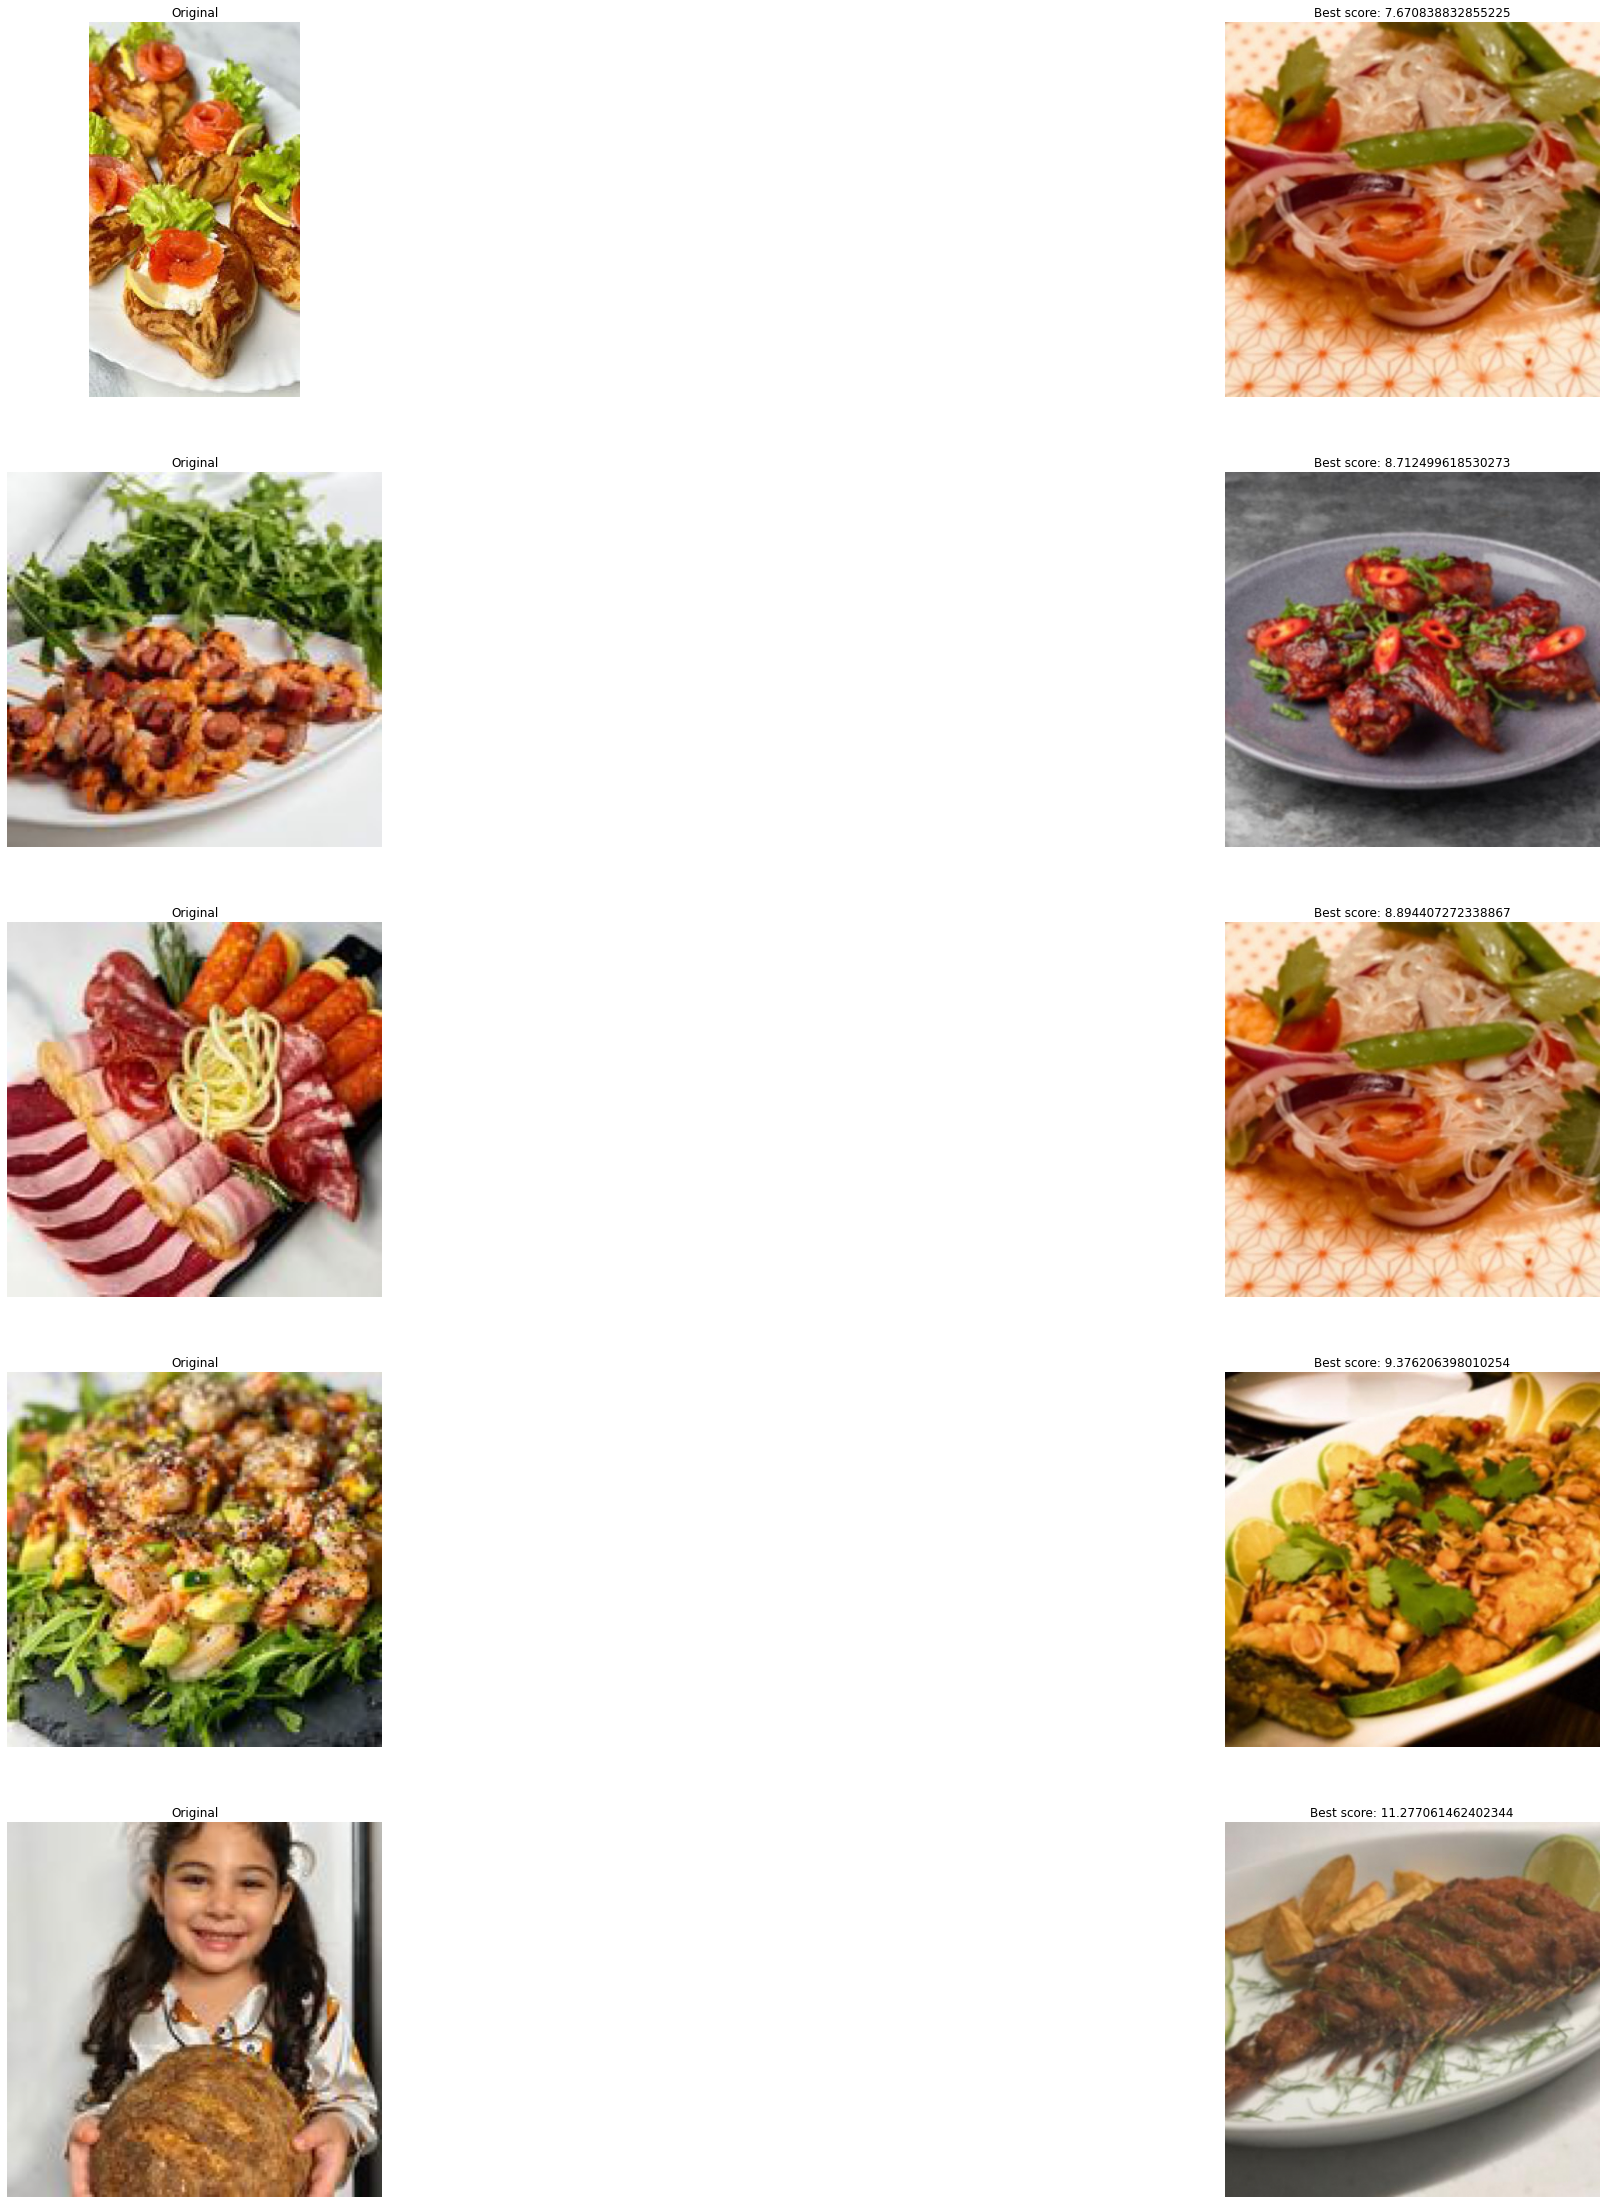

In [24]:
show_best_dishes(restaraunt_scores[1]['best_dishes'])